# Ejercicio 1: Implementación de los métodos

In [ ]:
install.packages("randomForest")
install.packages("kernlab")
install.packages("ggbiplot")
library(ggbiplot)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Wrapper greedy forward

In [ ]:
#-------------------------------------------------------------------------------------
# AVISO: codigo de demostracion
# No es optimo, no es la mejor solucion
#
#Funcion general para forward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#list.feat <-numero de orden de importancia de las variables, primero la mas relevante

#-------------------------------------------------------------------------------------
library(randomForest)
library(kernlab)
library(MASS)

forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]		#total de features
	num.feat<-1				#numero actual de features
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	#ranking inicial: elijo la variable con menor error de prediccion
	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train<-x[,i,drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	#guardo la variable con minimo error como primera en mi lista de elegidas. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego a la lista del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
		    features<-c(list.feat[1:num.feat],keep.feat[i])
			x.train<-x[,features]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1 #proximo paso
	}

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",list.feat,"\n")
	}

 	return(list.feat)

}


#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
	return ( ksvm(x.train, y, type=type,kernel=kernel,C=C,cross = cross)@cross )
}


#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))

	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
	num.feat<-dim(x.train)[2]
	tot.problems<-nlevels(y)*(nlevels(y)-1)/2

	m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)

	w<-rep(0.0,num.feat)
	for(i in 1:tot.problems) for(feat in 1:num.feat)
		w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
	rank.list<-sort(w,decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}



Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha




## Wrapper greedy backward

In [ ]:
backward.ranking <- function(x,y,method,verbosity=0,... )
{
	max.feat<-dim(x)[2]		#total de features
	num.feat<-max.feat-1			#numero actual de features
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset quitando sólo esa variable, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train<-x[,-i,drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	#guardo la variable con minimo error como la última en importancia. Guardo una lista keep.feat con las que me quedan para seguir eliminando.
	best.index <- tail(which(class.error == min(class.error)), 1)
	keep.feat <- list.feat[-best.index]
	list.feat[max.feat] <- best.index

	if(verbosity>1) cat("\nErrors: ", class.error)
	if(verbosity>1) cat("\nFeature removed: ", list.feat[max.feat])
	if(verbosity>1) cat("\nFeatures left: ", keep.feat, "\n")

  #loop principal. A cada paso elimino todas las variables disponibles, de a una, le mido el error y descarto la de minimo error. Hasta llegar a descartar todas.
	while(num.feat>1){
		class.error<-double(num.feat)

		for(i in 1:(num.feat)){
		  removed_features <- c(list.feat[(num.feat+1):max.feat],keep.feat[i])
			x.train<-x[,-removed_features,drop=F]

			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}

		best.index<-which.min(class.error)
		list.feat[num.feat] <- keep.feat[best.index]

		keep.feat <- keep.feat[-best.index]
		num.feat <- num.feat - 1

		if(verbosity>2) cat("\nErrors:", class.error)
		if(verbosity>2) cat("\nFeature removed:", list.feat[num.feat+1])
		if(verbosity>2) cat("\nFeatures left:", keep.feat, "\n")
	}

	list.feat[1] <- keep.feat[1]

	if(verbosity>3){
		cat("\n---------\nFinal ranking:")
		cat("\nFeatures:",list.feat,"\n")
	}

 	return(list.feat)

}

## Filter con test no-paramétrico (Kruskal-Wallis)

In [ ]:
kw.ranking <- function(x,y,verbosity=0)
{
	max.feat<-dim(x)[2]

  tests <- 1:max.feat

  for (i in 1:max.feat) {
    feat <- x[,i]
    tests[i] <- (kruskal.test(feat,y)$statistic)
  }

  ranking <-sort(tests, decreasing=TRUE, index=T)$ix

  if (verbosity > 0) cat("Stats:", tests, "\nRanking:", ranking)

  return(ranking)
}

## RFE

In [ ]:
rfe.ranking <- function(x,y,method,verbosity=0,...)
{
  max.feat<-dim(x)[2]

  list.feat <- 1:max.feat

  list.rank <- 1:max.feat

  for (i in 1:max.feat) {
    x.train<-x[,list.feat,drop=F]

		curr_rank <- do.call(method, c(list(x.train, y), list(...)) )$feats

    last_ranked_feat <- curr_rank[1]

    if (verbosity>1) cat("Removing feature:", list.feat[last_ranked_feat], "\n")

    list.rank[max.feat + 1 - i] <- list.feat[last_ranked_feat]
    list.feat <- list.feat[-last_ranked_feat]
  }

  if (verbosity>2) cat("\nFinal ranking:", list.rank)

  return(list.rank)
}

# Ejercicio 2: Análisis de datosA y datosB

In [ ]:
crea.ruido.unif<-function(n=100,d=2){
  x<-runif(2*n*d,min=-1)	#genero los datos
  dim(x)<-c(2*n,d)
  return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}


## Creación de los datasets

In [ ]:
#---------------------------------------------------------------------------
#CREA DATASET datosA
#Dataset artificial con orden de importancia: 8-6-4-2
#---------------------------------------------------------------------------

d<-10
n<-1000
datos<-crea.ruido.unif(n=n,d=d)

#tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,d+1]<-sign(datos[sub,8])
#tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
sub<-shuffle[(dim(datos)[1]*0.5):(dim(datos)[1]*0.7)]
datos[sub,d+1]<-sign(datos[sub,6])
#tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
sub<-shuffle[(dim(datos)[1]*0.7):(dim(datos)[1]*0.8)]
datos[sub,d+1]<-sign(datos[sub,4])
#tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
sub<-shuffle[(dim(datos)[1]*0.8):(dim(datos)[1]*0.85)]
datos[sub,d+1]<-sign(datos[sub,2])
datos[,d+1]<-factor(datos[,d+1])

datosA<-datos

In [ ]:
#---------------------------------------------------------------------------
#CREA DATASET datosB
#Dataset artificial con dos variables relevantes (1-2) y dos variables que son importantes pero que no resuelven el problema (3-4)
#---------------------------------------------------------------------------
#generar n=100,d=8
d<-8
n<-1000
datos<-crea.ruido.unif(n=n,d=d)
#hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
datos[,d+1]<-sign(datos[,1]*datos[,2])
#hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,3]<-abs(datos[sub,3])*datos[sub,d+1]
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,4]<-abs(datos[sub,4])*datos[sub,d+1]
datos[,d+1]<-factor(datos[,d+1])

datosB<-datos

## Proyecciones

### datosA

Comenzamos realizando algunos plot simples.

En el primero, vemos las variables de a pares. Se puede ver que el signo de la variable 8 divide en gran parte las clases. Y por ejemplo cuando se grafica la variable 8 en conjunto con la variable 6 hay una división aún más notoria cuando ambas toman valores del mismo signo.

Luego hacemos plots de las variables 8 y 6 por separado. Se puede ver que el signo de la variable 8 determina la clase de gran parte de los puntos. Sucede lo mismo con el signo de la variable 6 aunque con menos puntos.

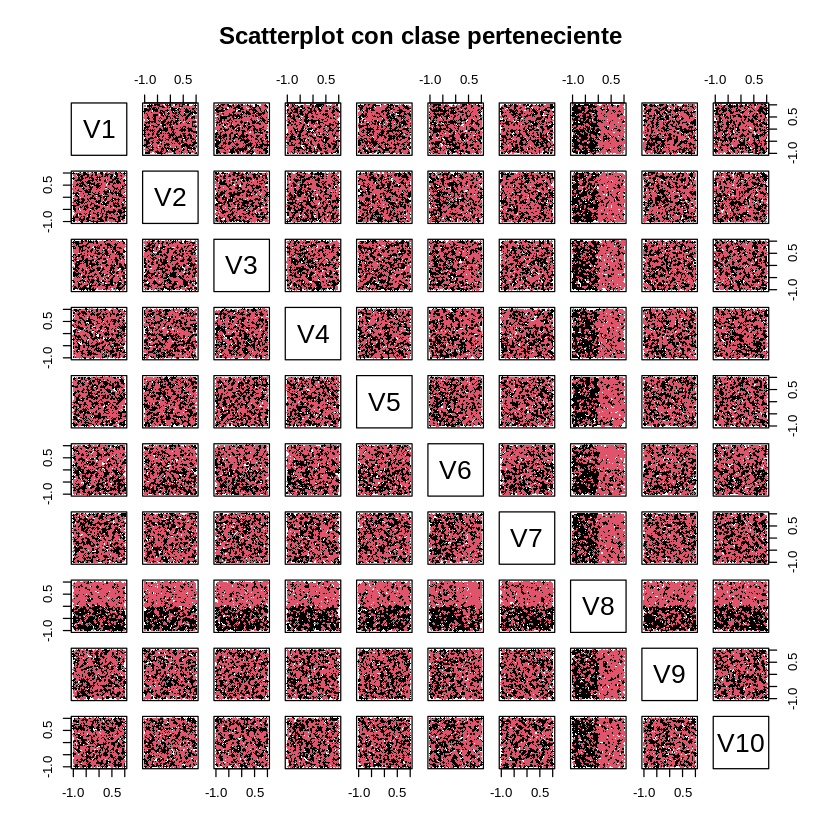

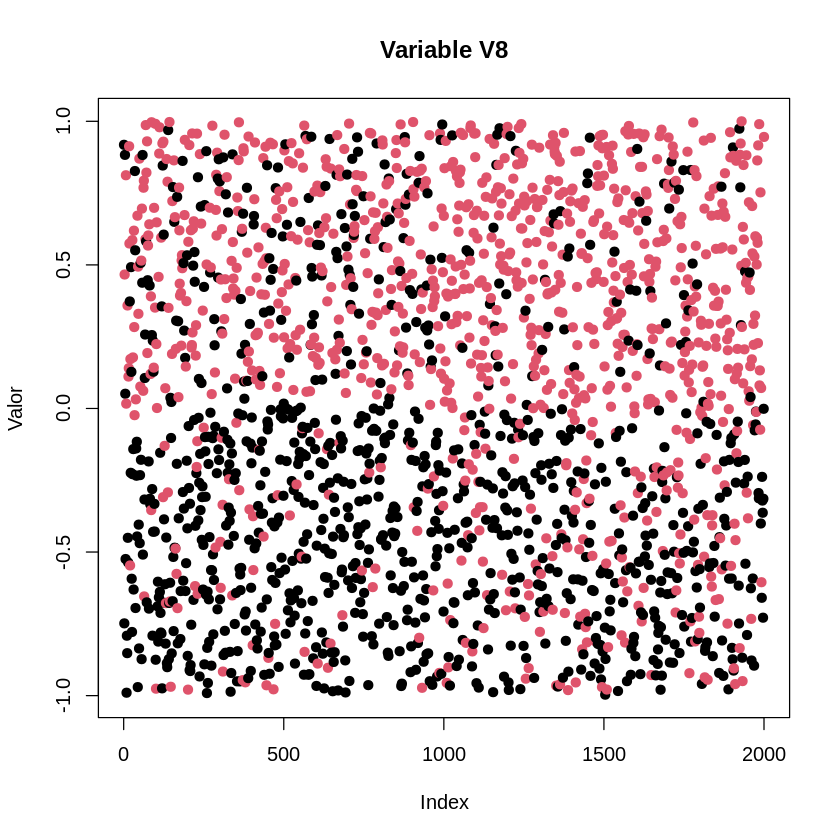

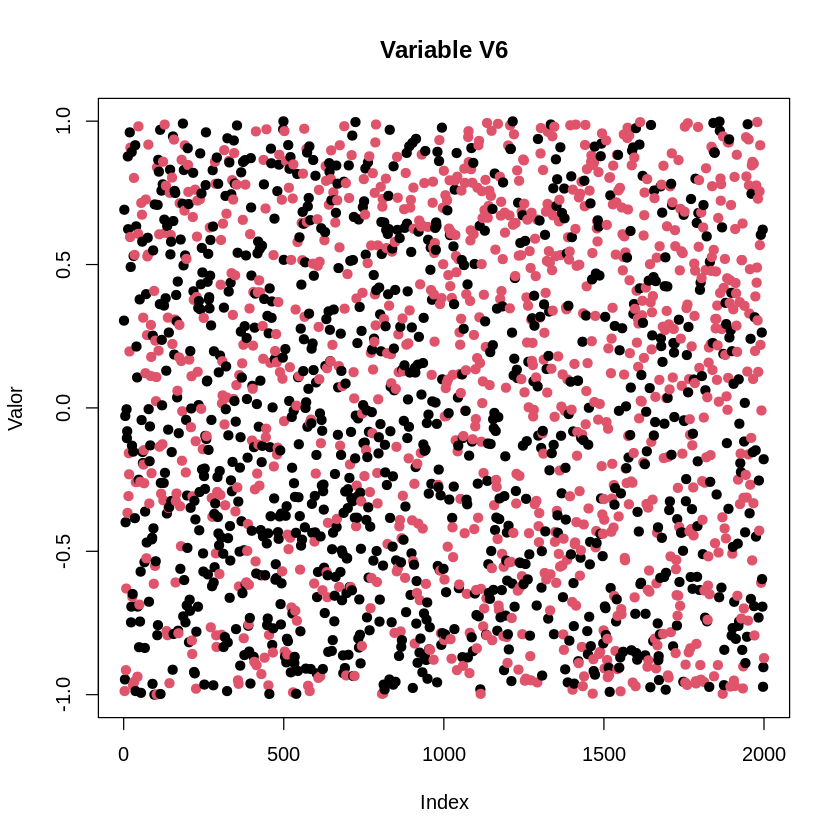

In [ ]:
pairs(datosA[,-11],
      main = "Scatterplot con clase perteneciente",
      col = as.integer(datosA[,11]),
      pch = 18,
      cex = 0.5)

plot(datosA[,8], main = paste("Variable", colnames(datosA)[8]), ylab = "Valor", pch = 19, col = as.integer(datosA[,11]))

plot(datosA[,6], main = paste("Variable", colnames(datosA)[6]), ylab = "Valor", pch = 19, col = as.integer(datosA[,11]))

Para concluir con la visualización del dataset datosA, realizamos un biplot de una PCA.

Si bien no se consigue visualizar una división clara de puntos según su clase, se ve claramente que la variable que más importancia tiene es la 8.

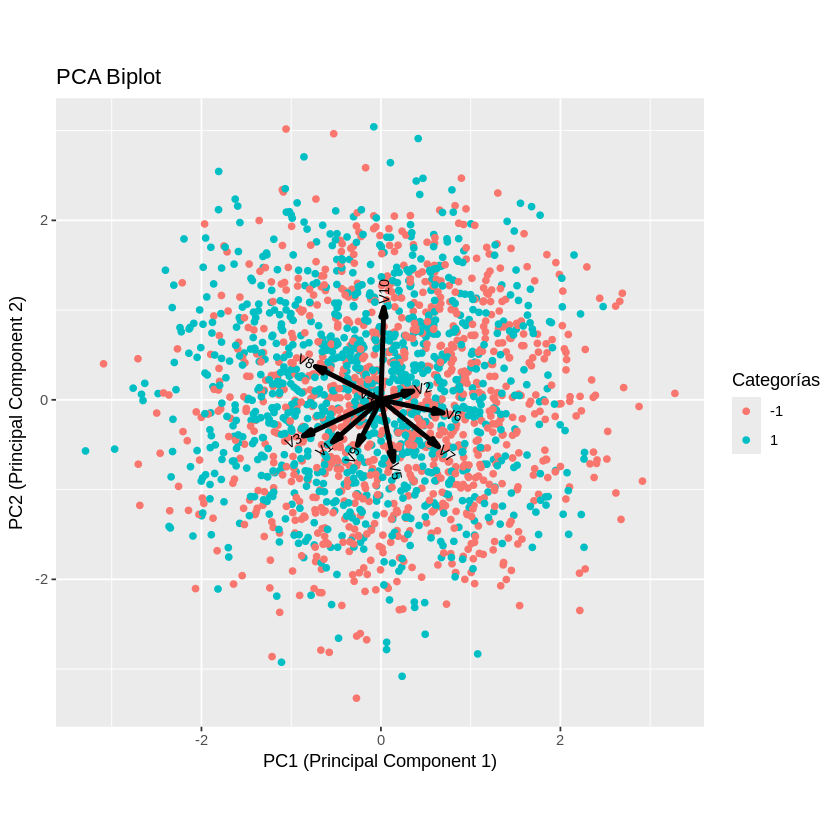

In [ ]:
print(ggbiplot(prcomp(datosA[,-11], scale = TRUE), obs.scale = 1, var.scale = 1, groups = datosA[,11]) +
      labs(title = "PCA Biplot",
           x = "PC1 (Principal Component 1)",
           y = "PC2 (Principal Component 2)",
           color = "Categorías"))

### datosB

Comenzamos con proyecciones simples.

Primero graficamos las clases de los puntos tomando de a pares de variables. Acá se puede ver que las variables 1 y 2 en conjunto determinan completamente la clase. Además las variables 3 y 4 estiman la clase pero con cierto error.

Luego se grafican las variables individualmente. Notar que tanto la 1 como la 2 no sirven para predecir la clase si se las mira de a una. En este caso pareciera que las variables 3 y 4 son más importantes.

In [2]:
pairs(datosB[,-9],
      main = "Scatterplot con clase perteneciente",
      col = as.integer(datosB[,9]),
      pch = 18,
      cex = 0.5)

plot(datosB[,1], main = paste("Variable", colnames(datosB)[1]), ylab = "Valor", pch = 19, col = as.integer(datosB[,9]))
plot(datosB[,2], main = paste("Variable", colnames(datosB)[2]), ylab = "Valor", pch = 19, col = as.integer(datosB[,9]))

# Vemos que la variable 3 separa más o menos las clases (correlacionadas en un 50% de los datos)
plot(datosB[,3], main = paste("Variable", colnames(datosB)[3]), ylab = "Valor", pch = 19, col = as.integer(datosB[,9]))
plot(datosB[,4], main = paste("Variable", colnames(datosB)[4]), ylab = "Valor", pch = 19, col = as.integer(datosB[,9]))

ERROR: Error: object 'datosB' not found


Finalmente se realiza la proyección biplot de la PCA. Como las clases están divididas según un XOR, no será posible ver esa división en esta proyección lineal. Más aún, se obtiene que los datos están separados pero con cierto solapamiento de clases. Las variables que parecen más importantes son la 3 y la 4.

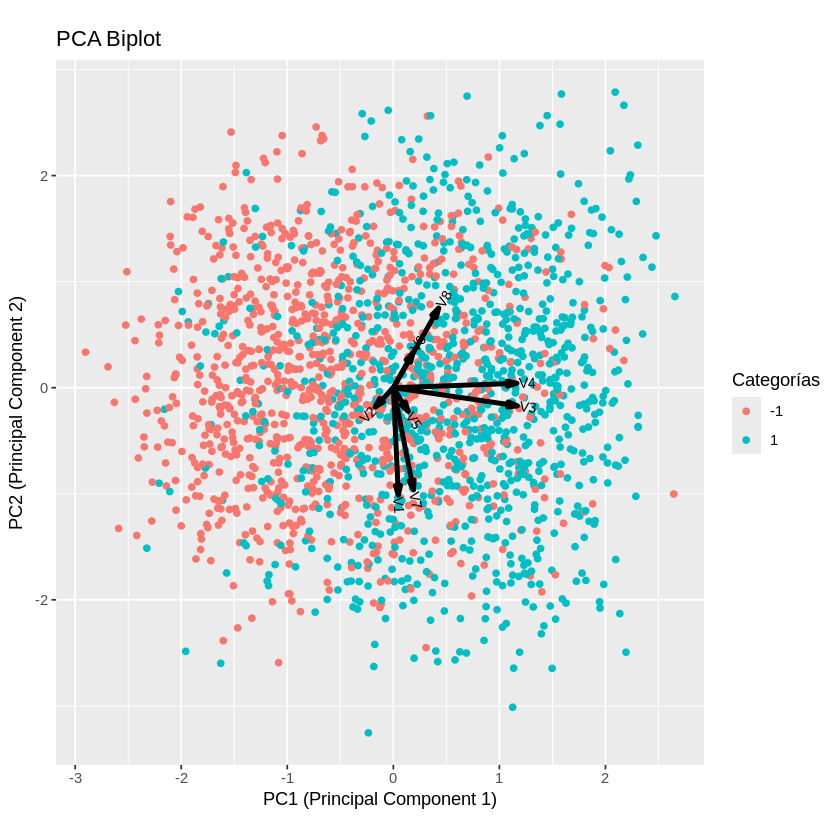

In [ ]:
print(ggbiplot(prcomp(datosB[,-9], scale = TRUE), obs.scale = 1, var.scale = 1, groups = datosB[,9]) +
      labs(title = "PCA Biplot",
           x = "PC1 (Principal Component 1)",
           y = "PC2 (Principal Component 2)",
           color = "Categorías"))


## Selección de variables

### Datos A

Se aplican los métodos de selección de variables, con distintos métodos de estimación del error y de rankings.

Para este dataset, todos los métodos funcionan de manera aceptable, clasificando casi siempre a las variables 8, 6 y 4 como las más importantes.

In [ ]:
FORW.rf <- forward.ranking(datosA[,-11],datosA[,11],method="rf.est",tot.trees=100,equalize.classes=F)
FORW.lda <- forward.ranking(datosA[,-11],datosA[,11],method="lda.est")

BACKW.rf <- backward.ranking(datosA[,-11],datosA[,11],method="rf.est",tot.trees=100,equalize.classes=F)
BACKW.lda <- backward.ranking(datosA[,-11],datosA[,11],method="lda.est")

KW <-kw.ranking(datosA[,-11], datosA[,11])

RFE.rf <- rfe.ranking(datosA[,-11],datosA[,11],method="imp.rf",tot.trees=100,equalize.classes=F)
RFE.linsvm <- rfe.ranking(datosA[,-11],datosA[,11],method="imp.linsvm")

cat("\nRankings (en orden de importancia decreciente)")
cat("\nForward con random forest\n", FORW.rf)
cat("\nForward con lda\n", FORW.lda)
cat("\nBackward con random forest\n", BACKW.rf)
cat("\nBackward con lda\n", BACKW.lda)
cat("\nKruskal-wallis\n", KW)
cat("\nRFE con random forest\n", RFE.rf)
cat("\nRFE con linear svm\n", RFE.linsvm)

 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  

Rankings (en orden de importancia decreciente)
Forward con random forest
 8 5 3 9 2 4 10 1 6 7
Forward con lda
 8 10 7 9 1 5 3 2 4 6
Backward con random forest
 8 6 2 4 3 9 10 7 1 5
Backward con lda
 8 10 9 5 1 7 3 2 4 6
Kruskal-wallis
 8 6 2 4 1 3 10 7 9 5
RFE con random forest
 8 6 2 7 4 3 10 9 5 1
RFE con linear svm
 8 6 2 4 9 1 5 7 3 10

### Datos B

Para este dataset, se pueden realizar algunas consideraciones.

El método Kruskal-Wallis es de filtro univariado, entonces no es capaz de detectar la importancia conjunta de las variables 1 y 2.

Los métodos que usan lda como estimación de error o linear svm como método de ranking le dan mayor importancia a las variables 3 y 4. Esto es porque no pueden resolver el XOR.

Por último, los métodos multivariados wrapper son los que ponen a las variables 1 y 2 como las más importantes.

In [ ]:
FORW.rf <- forward.ranking(datosB[,-9],datosB[,9],method="rf.est",tot.trees=50,equalize.classes=F)
FORW.lda <- forward.ranking(datosB[,-9],datosB[,9],method="lda.est")

BACKW.rf <- backward.ranking(datosB[,-9],datosB[,9],method="rf.est",tot.trees=50,equalize.classes=F)
BACKW.lda <- backward.ranking(datosB[,-9],datosB[,9],method="lda.est")

KW <-kw.ranking(datosB[,-9], datosB[,9])

RFE.rf <- rfe.ranking(datosB[,-9],datosB[,9],method="imp.rf",tot.trees=50,equalize.classes=F)
RFE.linsvm <- rfe.ranking(datosB[,-9],datosB[,9],method="imp.linsvm",C=100)

cat("\nRankings (en orden de importancia decreciente)")
cat("\nForward con random forest\n", FORW.rf)
cat("\nForward con lda\n", FORW.lda)
cat("\nBackward con random forest\n", BACKW.rf)
cat("\nBackward con lda\n", BACKW.lda)
cat("\nKruskal-wallis\n", KW)
cat("\nRFE con random forest\n", RFE.rf)
cat("\nRFE con linear svm\n", RFE.linsvm)

 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  

Rankings (en orden de importancia decreciente)
Forward con random forest
 4 3 2 1 5 8 6 7
Forward con lda
 4 5 8 2 3 1 7 6
Backward con random forest
 1 2 7 6 5 8 4 3
Backward con lda
 3 7 8 4 2 1 5 6
Kruskal-wallis
 4 3 1 7 2 8 6 5
RFE con random forest
 2 1 3 4 7 8 5 6
RFE con linear svm
 4 3 1 7 2 5 8 6

# Ejercicio 3: Selección de variables con dataset diagonal

In [ ]:
library(MASS)

gen_diag_df <- function(n = 20000, d=2, C=1) {
  mean_vector1 <- rep(1,d)
  mean_vector2 <- rep(-1,d)

  cov_matrix <- diag((C * sqrt(d))^2, d)

  samples1 <- mvrnorm(n = n/2, mu = mean_vector1, Sigma = cov_matrix)
  samples2 <- mvrnorm(n = n/2, mu = mean_vector2, Sigma = cov_matrix)

  df_samples1 <- as.data.frame(samples1)
  df_samples1$y <- factor(1)

  df_samples2 <- as.data.frame(samples2)
  df_samples2$y <- factor(-1)

  df <- rbind(df_samples1, df_samples2)

  return(df)
}

In [ ]:
calculate_method <- function() {
  df <- gen_diag_df(n=100,d=10,C=2)

  num_noise_cols <- 90
  noise <- matrix(runif(100 * num_noise_cols, min = -1, max = 1), nrow = 100, ncol = num_noise_cols)

  df_with_noise <- cbind(df[,-11], noise, df$y)

  # Calcular los rankings

  FORW.rf <- forward.ranking(df_with_noise[,-101],df_with_noise[,101],method="rf.est",tot.trees=100,equalize.classes=F)
  BACKW.rf <- backward.ranking(df_with_noise[,-101],df_with_noise[,101],method="rf.est",tot.trees=100,equalize.classes=F)
  KW <-kw.ranking(df_with_noise[,-101], df_with_noise[,101])

  RFE.rf <- rfe.ranking(df_with_noise[,-101],df_with_noise[,101],method="imp.rf",tot.trees=100,equalize.classes=F)

  # Calcular el porcentaje de aciertos para cada método

  FORW.perc <- sum(FORW.rf[1:10] <=10) * 10

  BACKW.perc <- sum(BACKW.rf[1:10] <=10) * 10

  KW.perc <- sum(KW[1:10] <=10) * 10

  RFE.perc <- sum(RFE.rf[1:10] <=10) * 10

  return(list(
    FORW_perc = FORW.perc,
    BACKW_perc = BACKW.perc,
    KW_perc = KW.perc,
    RFE_perc = RFE.perc
  ))
}


forw.total <- 0
backw.total <- 0
kw.total <- 0
rfe.total <- 0

iterations <- 30

cat("Progreso: ")
for (i in 1:iterations) {
  cat(i," ")
  flush.console()
  percentages <- calculate_method()
  forw.total <- forw.total + percentages$FORW_perc
  backw.total <- backw.total + percentages$BACKW_perc
  kw.total <- kw.total + percentages$KW_perc
  rfe.total <- rfe.total + percentages$RFE_perc
}

cat("\n")
cat("Porcentaje de aciertos (Forward):", forw.total/iterations, "%\n")
cat("Porcentaje de aciertos (Backward):", backw.total/iterations, "%\n")
cat("Porcentaje de aciertos (Kruskal-Wallis):", kw.total/iterations, "%\n")
cat("Porcentaje de aciertos (RFE):", rfe.total/iterations, "%\n")

Progreso: 1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  
Porcentaje de aciertos (Forward): 17 %
Porcentaje de aciertos (Backward): 12 %
Porcentaje de aciertos (Kruskal-Wallis): 39 %
Porcentaje de aciertos (RFE): 29 %


Estos resultados se deben a que hay pocos datos con muchas variables, de las cuales la gran mayoría son ruido. Esto hace que los métodos que usan el predictor final para evaluar la importancia de las variables hagan "overfitting".

Como hay pocos registros de datos, pero tienen muchas variables de ruido habrá algún conjunto de las últimas que "de casualidad" predigan la clase target.

Por lo tanto el método con mejor resultado es Kruskall-Wallis que ordena las variables con un criterio de importancia independiente del predictor.

# Ejercicio 4: Análisis de dataset gimnasio

Este dataset ofrece una visión detallada de las rutinas de ejercicio, atributos físicos y métricas de condición física de los miembros de un gimnasio. Contiene 973 muestras de datos del gimnasio, incluidas métricas clave de rendimiento como la frecuencia cardíaca, calorías quemadas y la duración del entrenamiento.

Se elige como clase target a Fat_Percentage. Esta es una variable continua, la cual será divida en clases de acuedo a distintos intervalos.

Comenzamos cargando el dataset, convirtiendo algunas variables no numéricas y quitando la variable BMI ya que está muy correlacionada con Fat_Percentage.

In [1]:
data <- read.csv("/content/gym_members_exercise_tracking.csv")

data$Gender <- as.numeric(as.factor(data$Gender))

data$Workout_Type <- as.numeric(as.factor(data$Workout_Type))

data <- data[, !(names(data) %in% c("BMI"))]

# mover columna de Fat_Percentage a la ultima posicion
data <- data[, c(setdiff(names(data), "Fat_Percentage"), "Fat_Percentage")]

Warning message in file(file, "rt"):
“cannot open file '/content/gym_members_exercise_tracking.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


Ahora seccionamos la variable Fat_Percentage. Notar que tal como se ve en los histogramas, las clases no están equivalentemente representadas. Hay que tener en consideración que los modelos construidos a partir del mismo pueden tener sesgos hacia las clases mayoritarias y no generalizar bien para las que tienen menos puntos.

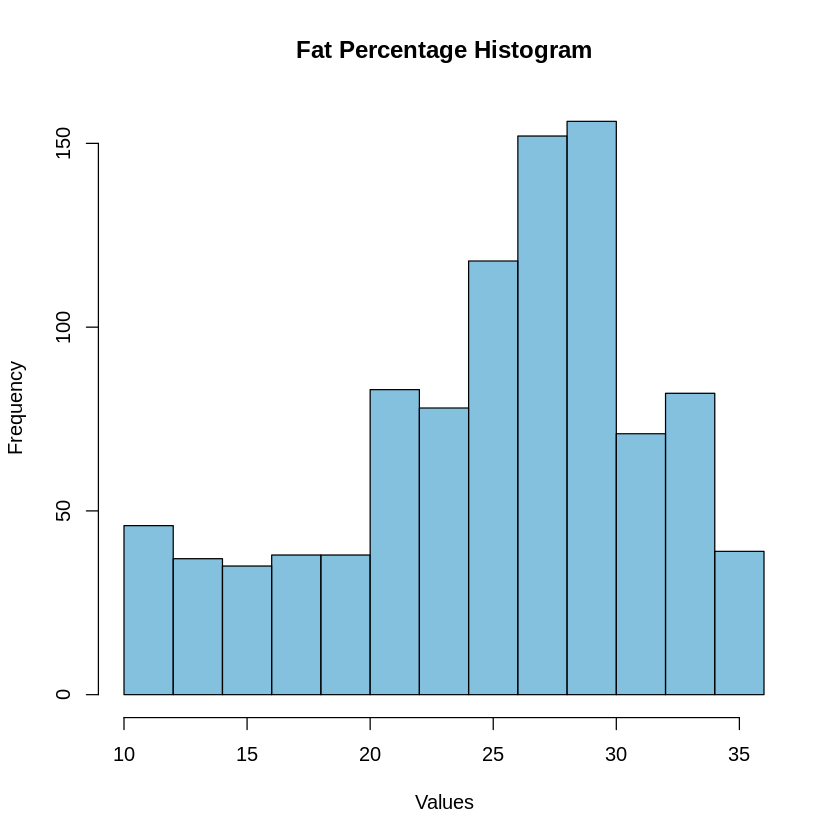

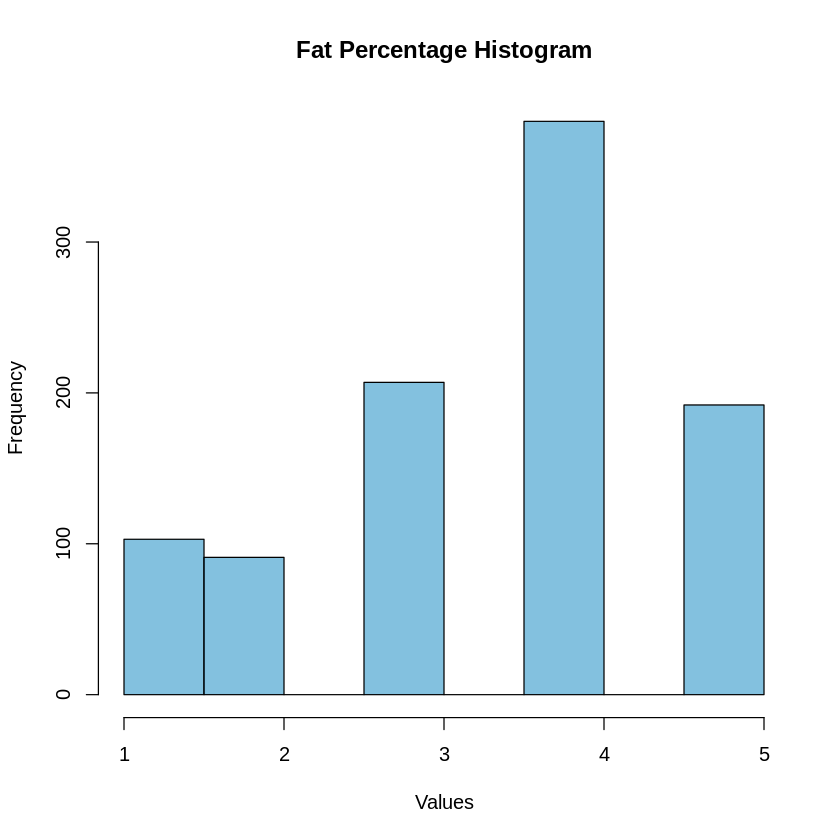

In [ ]:
hist(data$Fat_Percentage,
     col = rgb(0.2, 0.6, 0.8, 0.6),
     main = "Fat Percentage Histogram",
     xlab = "Values",
     ylab = "Frequency",
    )
# Divir la variable Fat_Percentage en clases
data$Fat_Percentage <- cut(data$Fat_Percentage,
                      breaks = 5,
                      labels = c("Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5"),
                      include.lowest = TRUE)

data$Fat_Percentage <- as.factor(data$Fat_Percentage)
hist(as.numeric(data$Fat_Percentage),
     col = rgb(0.2, 0.6, 0.8, 0.6),
     main = "Fat Percentage Histogram",
     xlab = "Values",
     ylab = "Frequency",
    )

A continuación se realizan histogramas para el resto de variables en pos de comprender aún más el conjunto de datos.

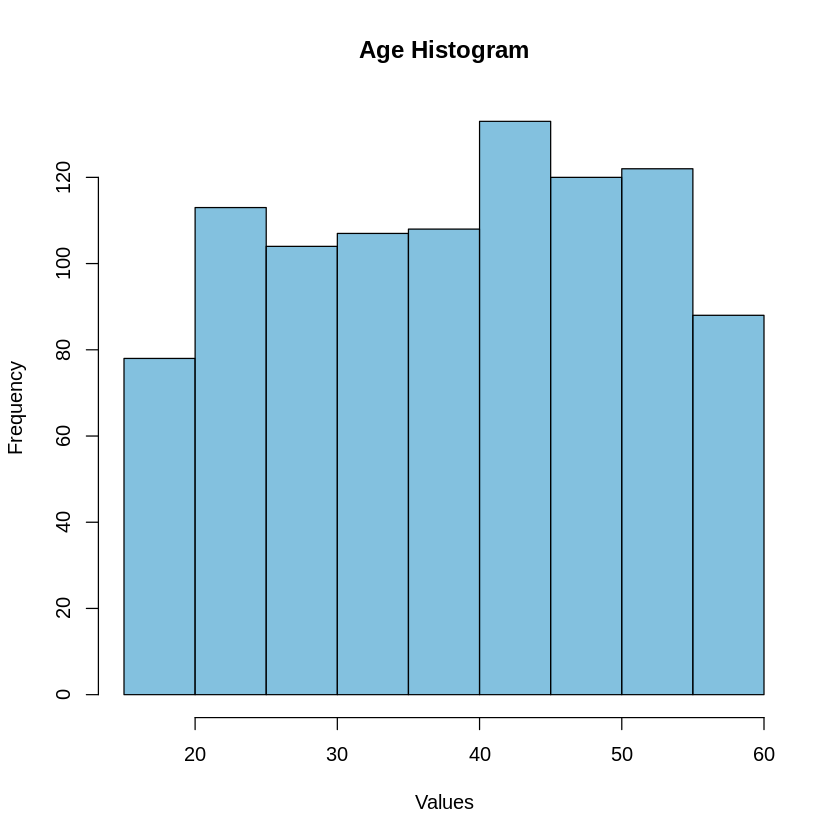

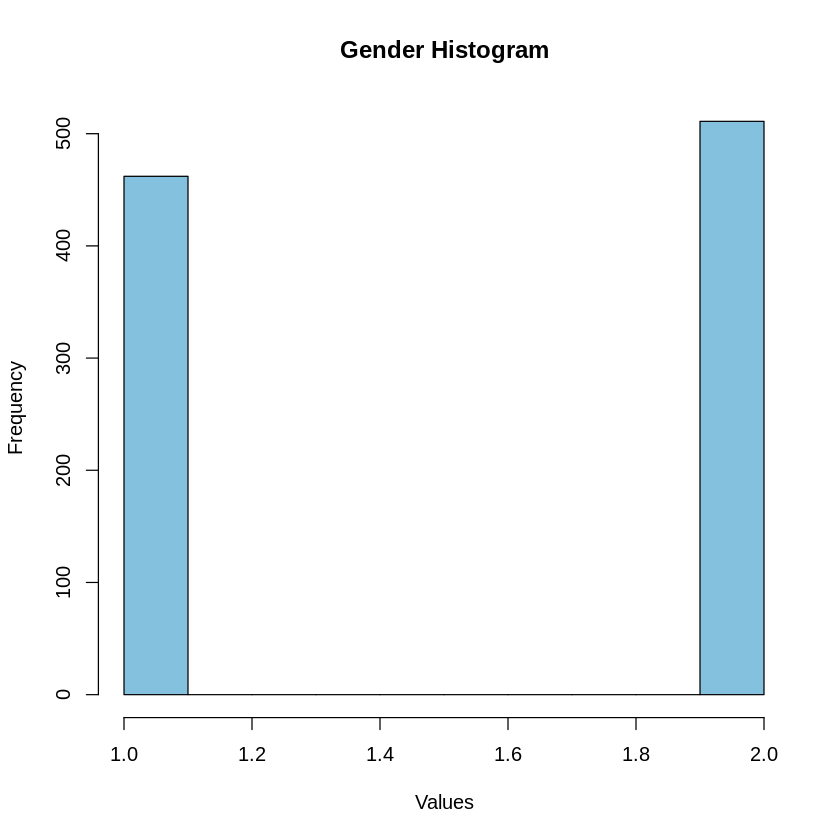

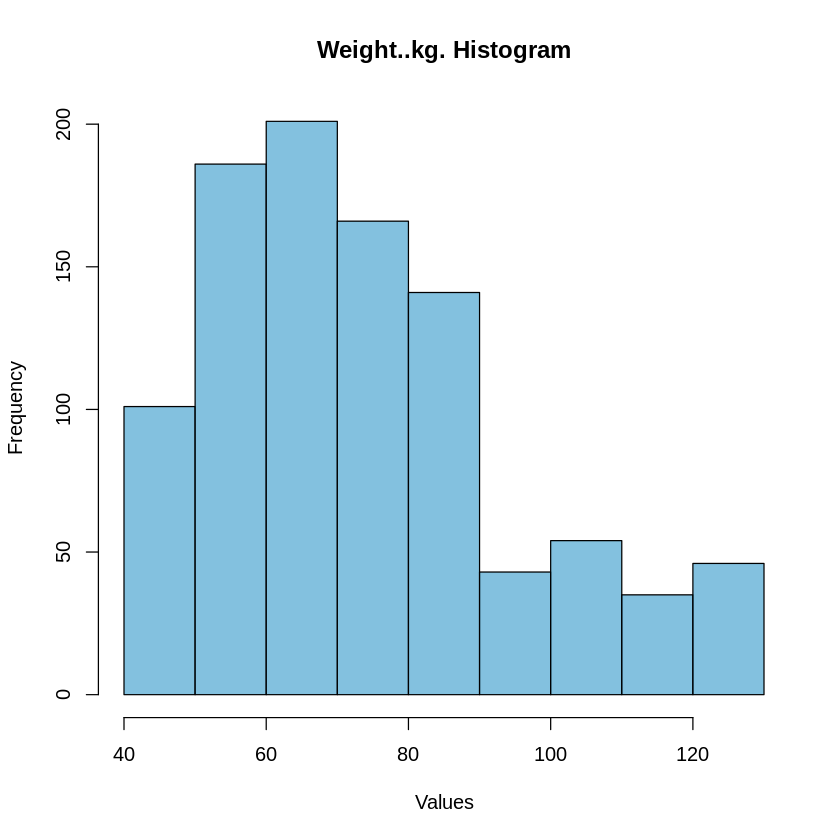

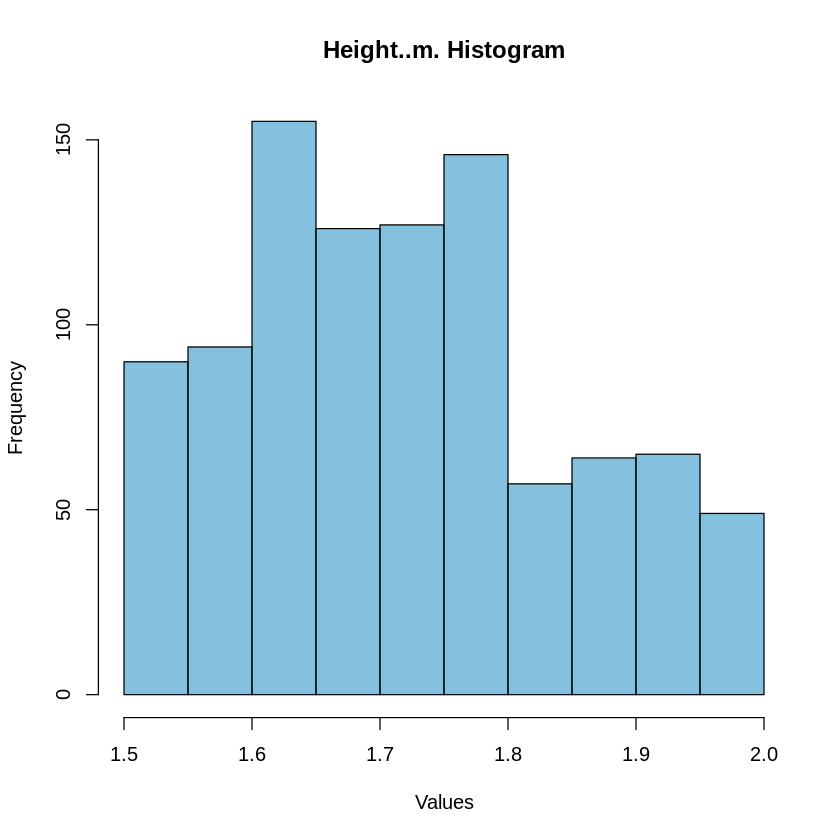

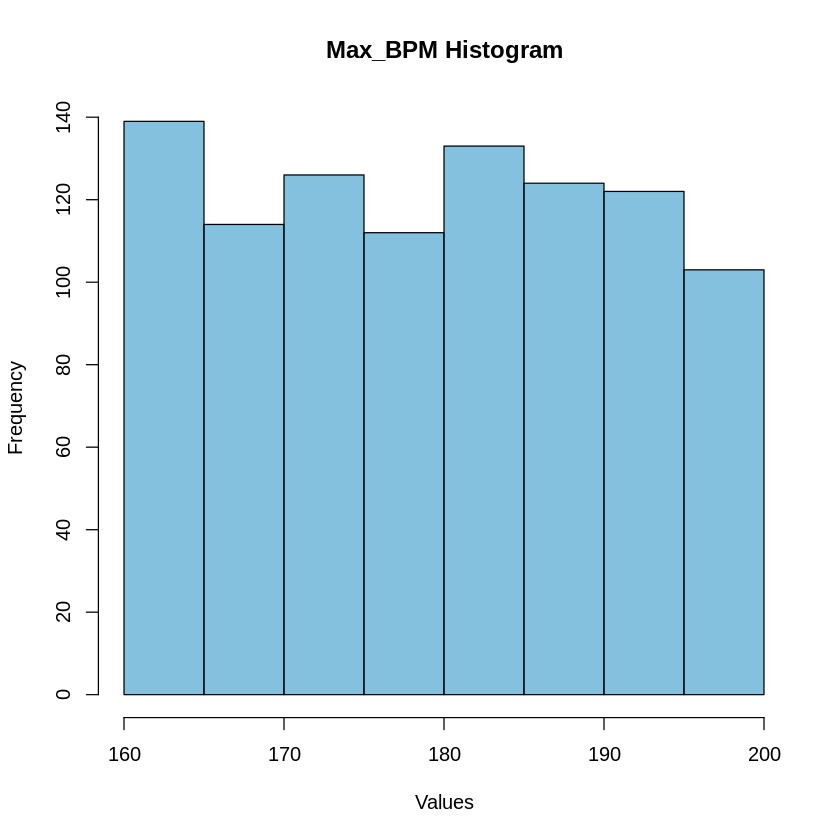

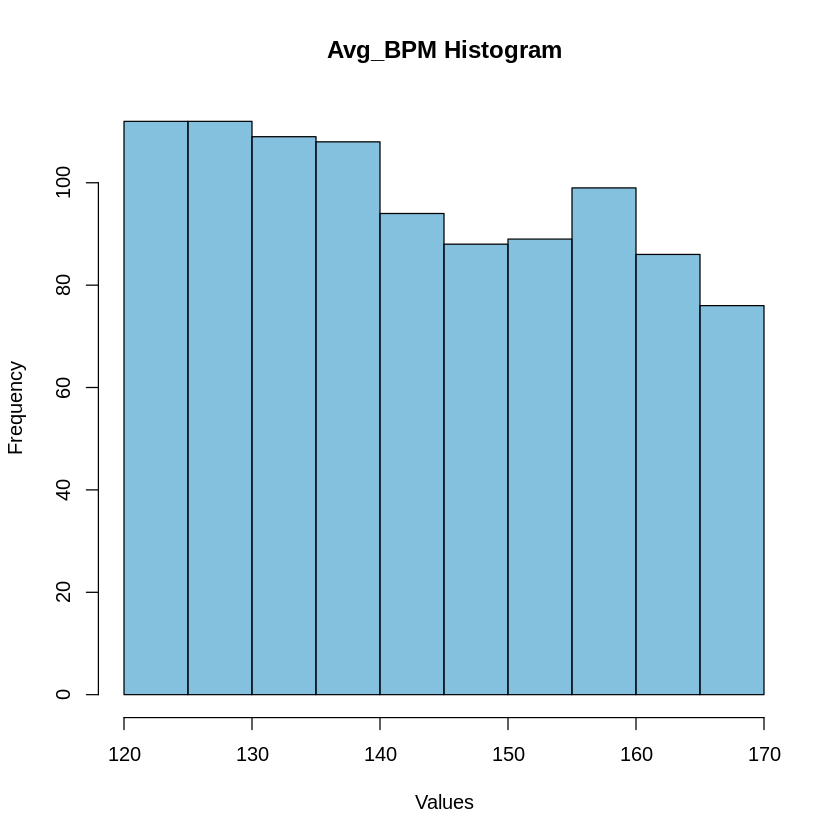

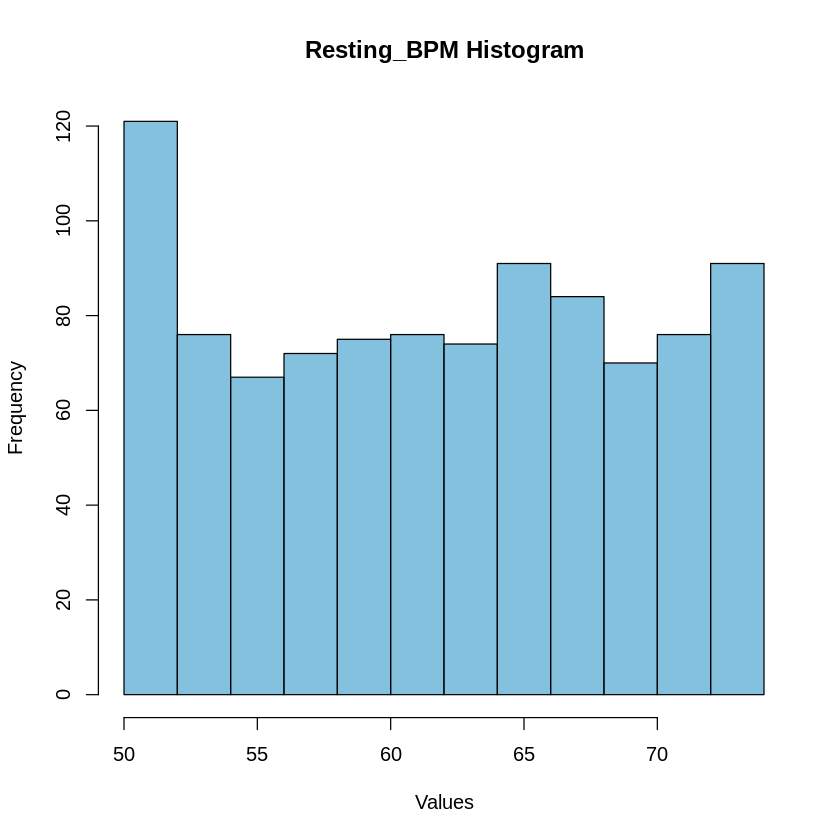

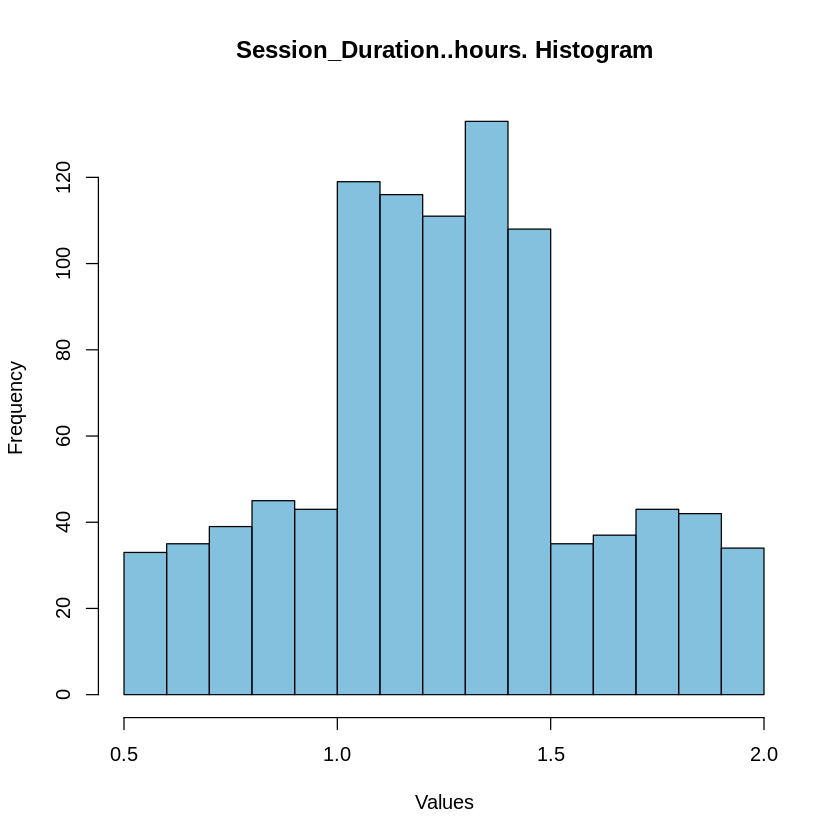

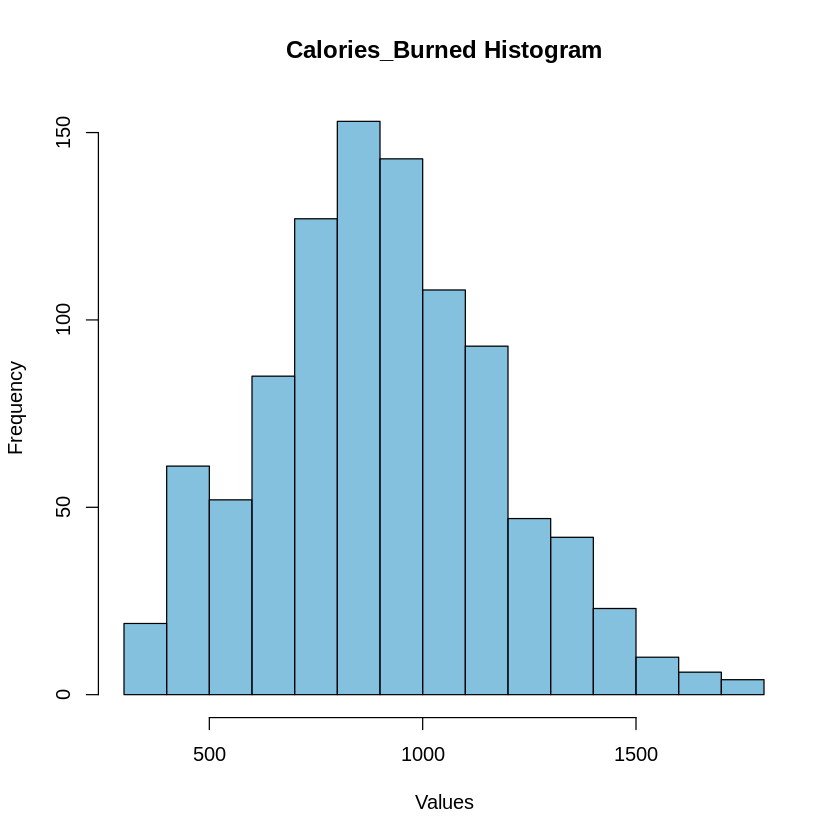

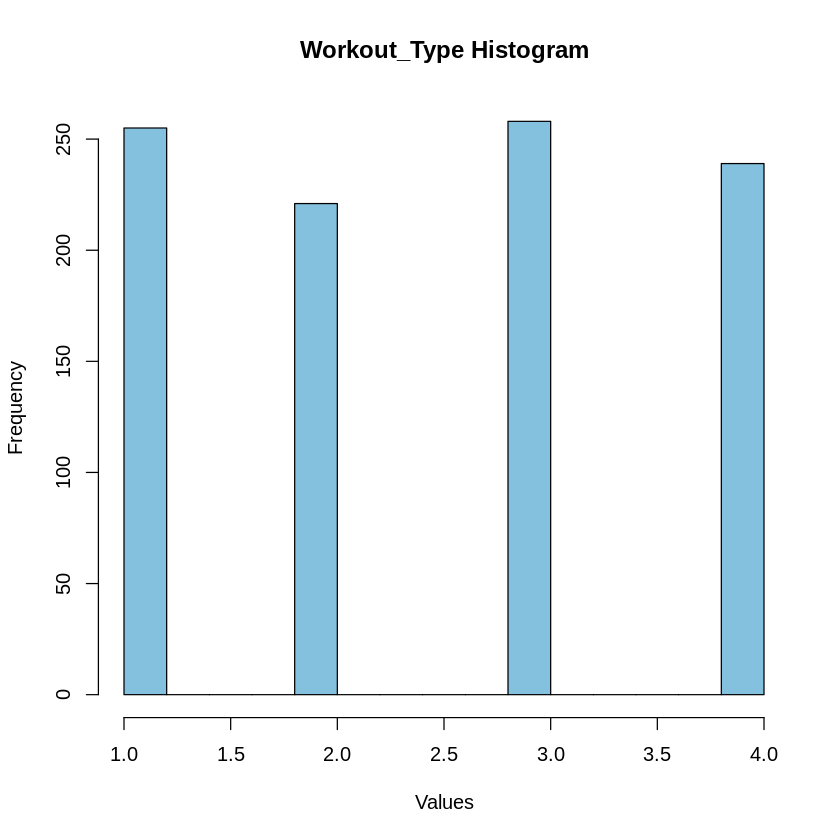

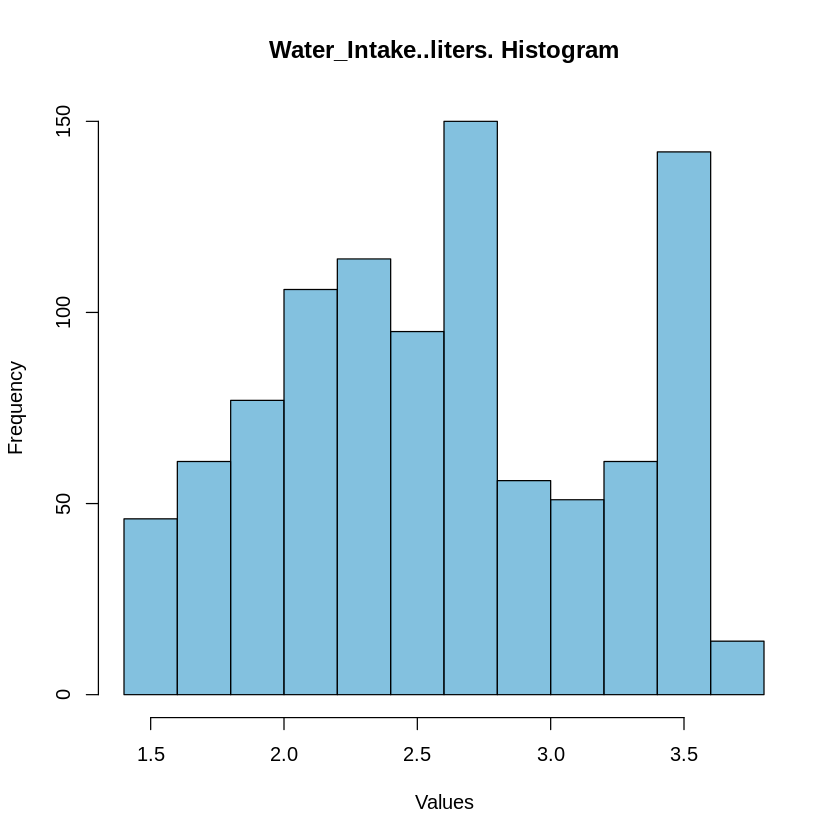

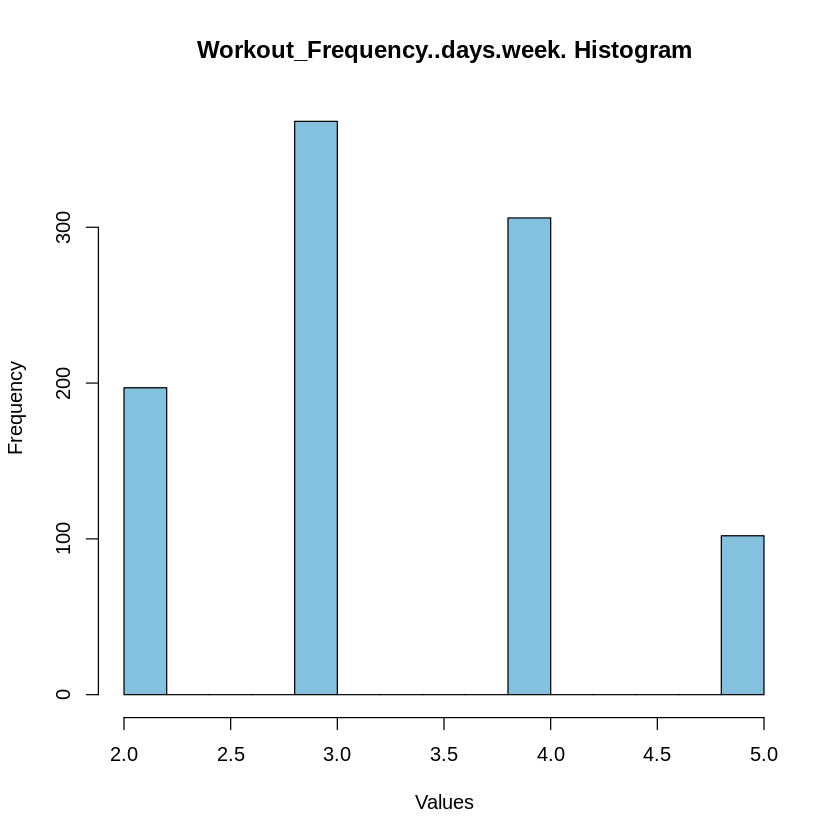

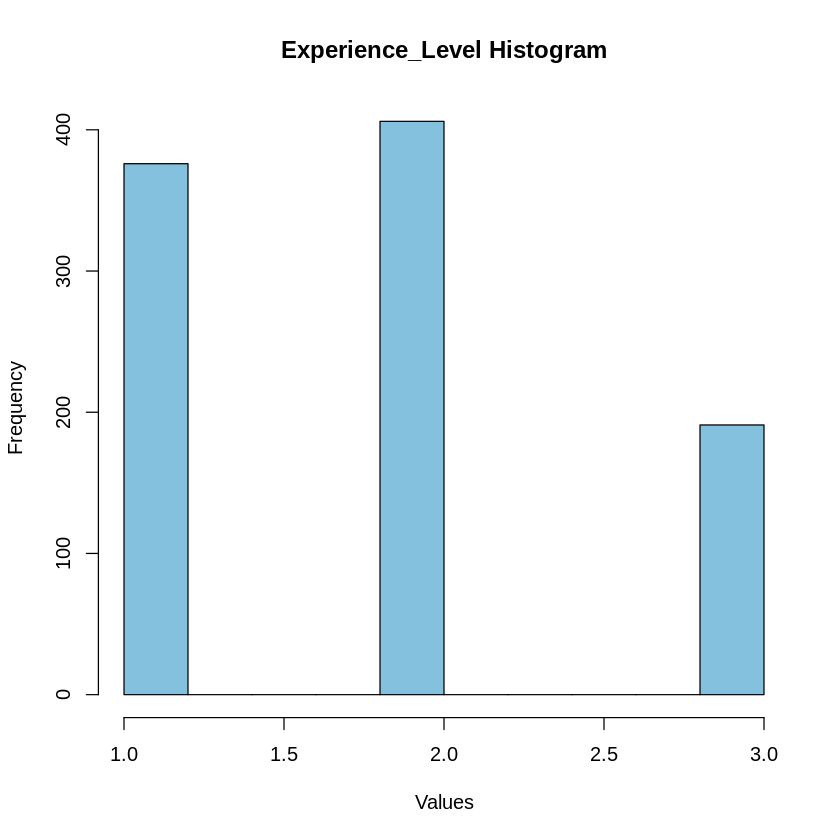

In [ ]:
for (i in 1:ncol(data)) {
  if (is.numeric(data[[i]])) {
    hist(data[,i],
     col = rgb(0.2, 0.6, 0.8, 0.6),
     main = paste(names(data)[i], "Histogram"),
     xlab = "Values",
     ylab = "Frequency",
    )
  }
}

Se realiza un plot tomando de a dos variables y asignando las clases mediante un color.

Se puede ver que variables como Session_Duration y Calories_Burned son muy útiles para identificar las clases 1 y 2 (azúl más oscuro).

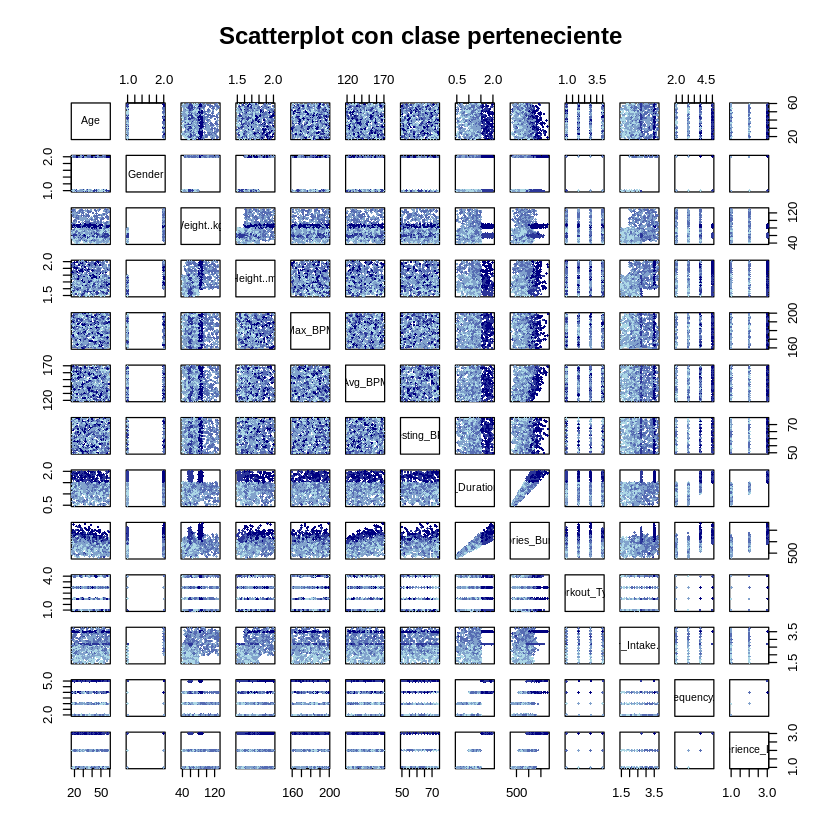

In [ ]:
num_classes <- length(unique(data[,14]))
colors <- colorRampPalette(c("navy", "lightblue"))(num_classes)

pairs(data[,-14],
      main = "Scatterplot con clase perteneciente",
      col = colors[as.integer(data[,14])],
      pch = 18,
      cex = 0.5)

Se presentan gráficos de las variables anteriormente mencionadas pero de manera individual esta vez.

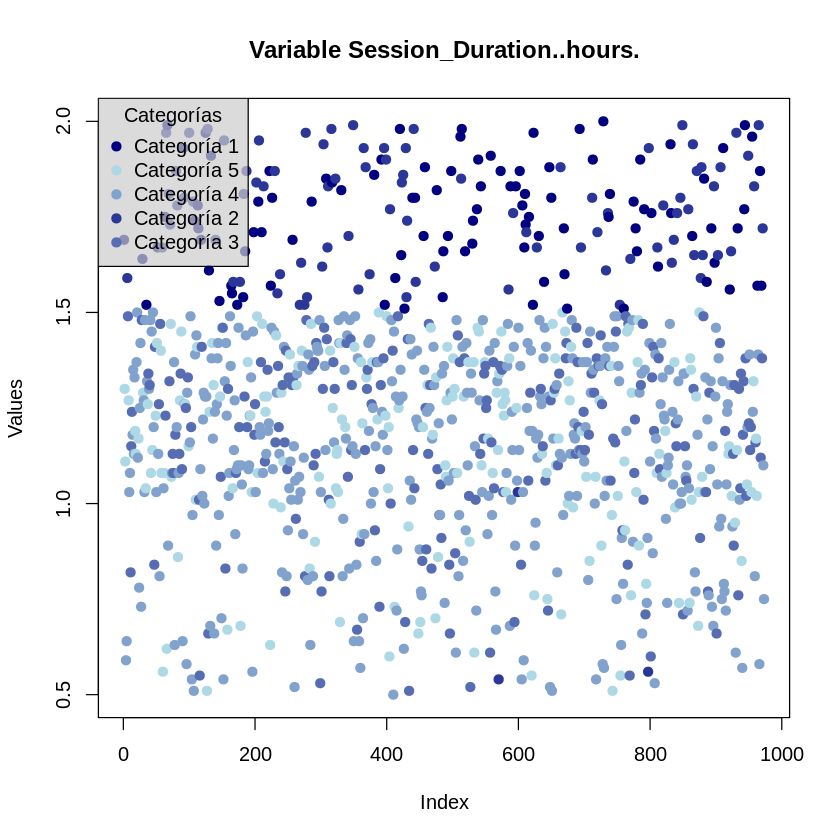

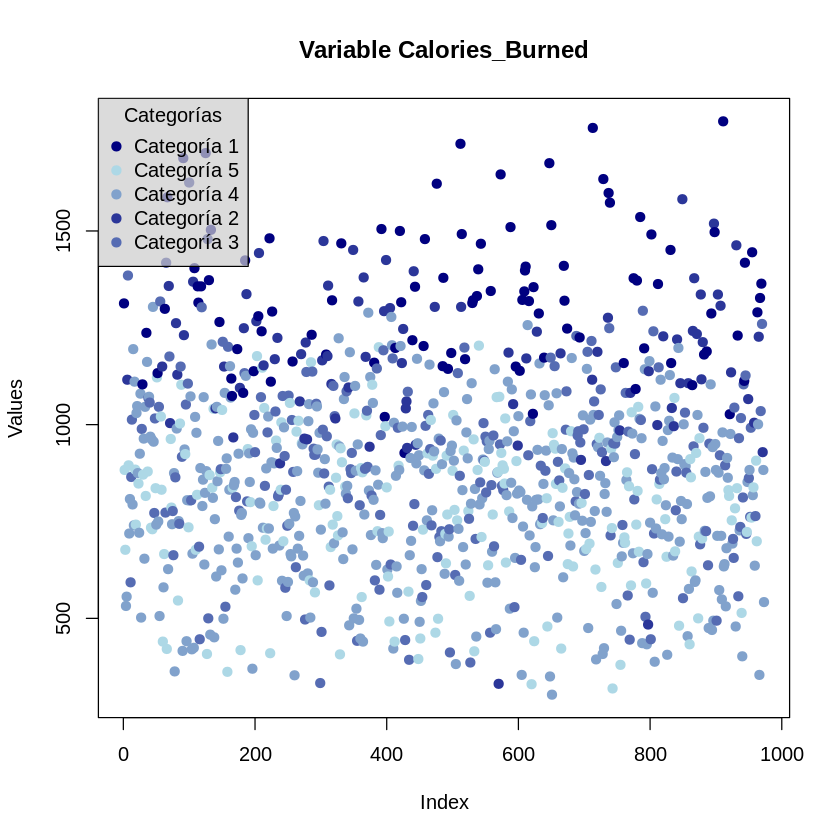

In [ ]:
unique_values <- unique(as.integer(data[, 14]))
legend_labels <- paste("Categoría", unique_values)

# La variable 8 separa las categorías 1 y 2
plot(data[,8],
     main = paste("Variable", colnames(data)[8]),
     ylab = "Values",
     pch = 19,
     col = colors[as.integer(data[,14])])

legend("topleft", bg = rgb(0.8, 0.8, 0.8, 0.7), legend = legend_labels, col = colors[unique_values], pch = 19, title = "Categorías")

# La variable 9 también separa las categorías pero con menor exactitud
plot(data[,9],
     main = paste("Variable", colnames(data)[9]),
     ylab = "Values",
     pch = 19,
     col = colors[as.integer(data[,14])])

legend("topleft", bg = rgb(0.8, 0.8, 0.8, 0.7), legend = legend_labels, col = colors[unique_values], pch = 19, title = "Categorías")


Finalmente realizamos una proyección biplot de la PCA.

Se pueden identificar claramente 4 clusters.

En un eje las variables Gender, Height y Weight son las más relevantes.

En el otro, las variables Calories_Burned, Session_Duration, Workout_Frequency son las más relevantes.

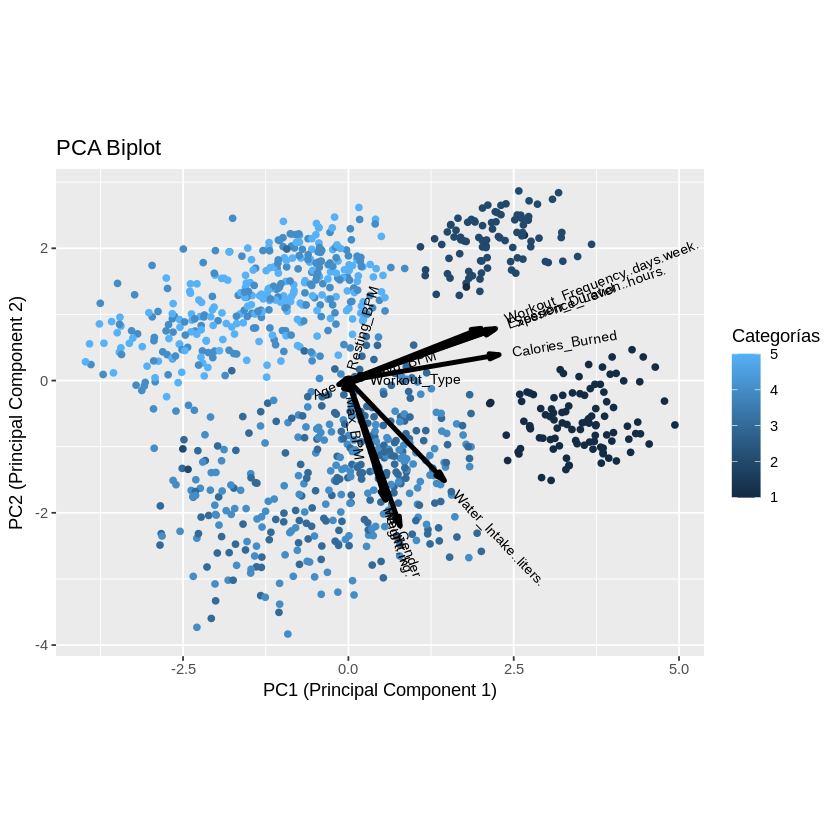

In [ ]:
print(ggbiplot(prcomp(data[,-14], scale = TRUE), obs.scale = 1, var.scale = 1, groups = as.numeric(data$Fat_Percentage)) +
      labs(title = "PCA Biplot",
           x = "PC1 (Principal Component 1)",
           y = "PC2 (Principal Component 2)",
           color = "Categorías")
      )

Concluimos el análisis aplicando los métodos de selección de variables.

Obtenemos resultados similares a lo visualizado anteriormente. Las mismas variables que se suponían importantes en los gráficos salen para todos los métodos en las primeras posiciones del ranking.

Se puede ver que las variables relacionadas al físico de las personas y al entrenamiento realizado son las más relevantes. Mientras que lo relacionado a las estadísiticas de pulsaciones obtenidas durante los entrenamientos no son tan relevantes para predecir el porcentaje graso.

In [ ]:
print_ranking <- function(ranking, method_name) {
  cat("Ranking usando", method_name, ":\n")
  cat("Ranking (índices):", ranking, "\n")
  cat("5 variables más relevantes (de mayor a menor):", colnames(data)[ranking[1:5]], "\n")

  cat("\n")
}

FORW.rf <- forward.ranking(data[,-14],data[,14],method="rf.est",tot.trees=100,equalize.classes=F)
BACKW.rf <- backward.ranking(data[,-14],data[,14],method="rf.est",tot.trees=100,equalize.classes=F)
KW <-kw.ranking(data[,-14], data[,14])
RFE.rf <- rfe.ranking(data[,-14],data[,14],method="imp.rf",tot.trees=100,equalize.classes=F)

print_ranking(FORW.rf, "Forward con random forest")
print_ranking(BACKW.rf, "Backward con random forest")
print_ranking(KW, "Kruskal-Wallis")
print_ranking(RFE.rf, "RFE con random forest")


Ranking usando Forward con random forest :
Ranking (índices): 11 13 10 4 2 1 7 8 3 5 6 9 12 
5 variables más relevantes (de mayor a menor): Water_Intake..liters. Experience_Level Workout_Type Height..m. Gender 

Ranking usando Backward con random forest :
Ranking (índices): 8 2 3 10 7 5 11 12 1 9 6 4 13 
5 variables más relevantes (de mayor a menor): Session_Duration..hours. Gender Weight..kg. Workout_Type Resting_BPM 

Ranking usando Kruskal-Wallis :
Ranking (índices): 2 13 8 11 9 12 3 4 5 7 6 10 1 
5 variables más relevantes (de mayor a menor): Gender Experience_Level Session_Duration..hours. Water_Intake..liters. Calories_Burned 

Ranking usando RFE con random forest :
Ranking (índices): 13 2 8 11 3 4 12 10 9 6 5 7 1 
5 variables más relevantes (de mayor a menor): Experience_Level Gender Session_Duration..hours. Water_Intake..liters. Weight..kg. 

